In [1]:
import inspect
import json

import asyncio
import aioredis

import nest_asyncio
nest_asyncio.apply()

import rx
from rx.subject import Subject
from rx.core import Observer, Observable, ConnectableObservable, typing
from rx.disposable import Disposable, CompositeDisposable
from rx import operators as ops

from dataclasses import dataclass, field
from typing import Type, Any, List, Tuple, Callable, Optional, Union, Awaitable, Coroutine, NamedTuple

import mape

In [4]:
from mape.redis import PubObserver, SubObservable
from mape.utils import LogObserver
from mape.typing import Message

from dataclasses import dataclass, field

@dataclass
class PayloadTest:
    name: str = 'ciao'
    number: int = 6
    numbers: List = field(default_factory=lambda: [1, 2, 3])

ciao = SubObservable(["A", "B"])
a = ciao.subscribe(LogObserver("A, B"))

ciao = SubObservable("B")
b = ciao.subscribe(LogObserver("B"))

pub_observer_a = PubObserver("A")
pub_observer_a.on_next(Message(value='a', src='src.A'))
pub_observer_a.on_next('a')
# pub_observer.on_error(Message(value="error", src='src2'))
# pub_observer.on_completed()

await asyncio.sleep(4)
# pub_observer.dispose()

print("B")

pub_observer_b = PubObserver("B")
pub_observer_b.on_next(Message(value=PayloadTest(), src='src.B'))
pub_observer_b.on_next(20)
# pub_observer.on_error(Message(value="error", src='src20'))
# pub_observer.on_completed()

await asyncio.sleep(4)
pub_observer_b.on_next('b1')
await asyncio.sleep(0.1)
pub_observer_b.on_next('b2')
await asyncio.sleep(0)
pub_observer_b.on_next('b3')
pub_observer_a.on_next('a1')
await asyncio.sleep(10)
pub_observer_a.on_next('a2')
await asyncio.sleep(1)

a.dispose()
b.dispose()

(9672) on next: Message(a, src.A, None, 0, 16:45:17.929) | A, B
(9672) on next: a | A, B
B
(9672) on next: Message(PayloadTest(name='ciao', number=6, numbers=[1, 2, 3]), src.B, None, 0, 16:45:21.931) | A, B
(8537) on next: Message(PayloadTest(name='ciao', number=6, numbers=[1, 2, 3]), src.B, None, 0, 16:45:21.931) | B
(9672) on next: 20 | A, B
(8537) on next: 20 | B
(8537) on next: b1 | B
(9672) on next: b1 | A, B
(9672) on next: b2 | A, B
(8537) on next: b2 | B
(9672) on next: b3 | A, B
(8537) on next: b3 | B
(9672) on next: a1 | A, B
(9672) on next: a2 | A, B


In [4]:
""" MANAGE TASK EXCEPTION """

import asyncio
import aioredis
import mape

import nest_asyncio
nest_asyncio.apply()

async def test_raise_unmanaged(param=None):
    while True:
        print(param)
        raise Exception('unmanaged')
        await asyncio.sleep(2)

@mape.utils.log_task_exception
async def test_raise_unmanaged_wrapped(param=None):
    while True:
        print(param)
        raise Exception('wrapped')
        await asyncio.sleep(2)

task = asyncio.create_task(test_raise_unmanaged('silent exception'))
await asyncio.sleep(4)
print("cancel")
task.cancel()

task = asyncio.create_task(mape.utils.task_exception(test_raise_unmanaged_wrapped('wrapped')))
await asyncio.sleep(4)
print("cancel")
task.cancel()

task = asyncio.create_task(test_raise_unmanaged_wrapped('decorated'))
await asyncio.sleep(4)
print("cancel")
task.cancel()

await asyncio.sleep(4)

silent exception


wrapped
Traceback (most recent call last):
  File "/home/muttley/Projects/SecondLevelDegrees/courses/Thesis/source/playground/mape/utils.py", line 129, in task_exception
    return await awaitable
  File "/tmp/ipykernel_176147/836816186.py", line 18, in test_raise_unmanaged_wrapped
    raise Exception('wrapped')
Exception: wrapped


cancel
wrapped


wrapped
Traceback (most recent call last):
  File "/home/muttley/Projects/SecondLevelDegrees/courses/Thesis/source/playground/mape/utils.py", line 129, in task_exception
    return await awaitable
  File "/tmp/ipykernel_176147/836816186.py", line 18, in test_raise_unmanaged_wrapped
    raise Exception('wrapped')
Exception: wrapped


cancel
decorated
cancel


In [1]:
!pip install git+https://github.com/plataux/purse.git

  Cloning https://github.com/plataux/purse.git to /tmp/pip-req-build-gab_ef0w
  Running command git clone -q https://github.com/plataux/purse.git /tmp/pip-req-build-gab_ef0w
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 13.7 MB 1.5 MB/s eta 0:00:01
  Created wheel for purse: filename=purse-0.21-py3-none-any.whl size=19446 sha256=62c1618b8d56cea7709d71bf74bece83d1d6891e9ff4ea2a3cb59324234ba7cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-b81_hk7c/wheels/b9/d2/8f/8baa5e4e0778b75c9283a9117d544eb81a58843a4a41a72a66
Successfully built purse
You should consider upgrading via the '/home/muttley/.pyenv/versions/3.8.12/envs/venv-3.8.12/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
import asyncio
import aioredis

import nest_asyncio
nest_asyncio.apply()

In [ ]:
async def main():
    local_list = ['a', 'b', 'c', 'd', 'e', 'f']

    # local Redis >= 6.0.x plain connection with default params
    red_con = aioredis.Redis()
    redis_key = 'redis_list'

    # The value_type defines the class to serialize to and from
    redis_list = RedisList(redis=red_con, rkey=redis_key, value_type=str)

    # Clear the list, in case it was previously populated
    await redis_list.clear()

    # extend a Redis list with a Python list
    await redis_list.extend(local_list)

    # async list comprehension
    print([x async for x in redis_list])

    # contains
    print(await redis_list.contains('f'))  # True
    print(await redis_list.contains('g'))  # False

    # getting the index of a value
    print(await redis_list.index('c'))  # 2
    print(await redis_list.index('g'))  # None, unlike a Python list that raises a ValueError

    # slicing
    print(await redis_list.slice(2, 5))  # ['c', 'd', 'e']

    # inserting values
    await redis_list.insert(2, 'x')
    await redis_list.insert(-2, 'y')

    # getitem
    assert await redis_list.getitem(2) == 'x'
    assert await redis_list.getitem(-3) == 'y'

    # some deque methods
    await redis_list.appendleft('z')
    await redis_list.pop()
    await redis_list.popleft()

asyncio.run(main())

In [2]:
import pickle
from pydantic import BaseModel

class Bau:
    def __init__(self, boh) -> None:
        self.ok2 = True
        self.boh = boh

class Ciao:
    def __init__(self) -> None:
        super().__init__()
        self.ok = True
        self.bau = Bau(3)

# Pydantic Model
class Plant(BaseModel):
    name: str = 'undefined'
    healthiness: float
    tasty: bool = False

class Three(Plant):
    color: str = 'green'

In [ ]:
async def main():
    redis = aioredis.Redis()

    k = RedisKeySpace(redis=redis, prefix='k:__app:', value_type=bytes)
    pickled_obj = pickle.dumps(Ciao())
    ret = await k.set('pickled', pickled_obj)
    print(ret)
    ret = await k.get('pickled')
    print(ret)
    unpickled_obj = pickle.loads(ret)
    print(unpickled_obj)

    print("-----------------"*3)

    k = RedisKeySpace(redis=redis, prefix='k:__app:', value_type=Three)
    obj = Three(healthiness = 6.6)
    ret = await k.set('pydantic', obj)
    print(ret)
    ret = await k.get('pydantic')
    print(ret)


asyncio.run(main())

In [12]:
import asyncio
import aioredis
from mape.knowledge import Knowledge

async def main():
    redis = aioredis.Redis()
    k = Knowledge(redis, '__prefix')

    obj = Three(healthiness = 6.6)
    ret = await k.keyspace.set('pickled', obj)
    print(ret)
    ret = await k.keyspace.get('pickled')
    print(ret)

    print("-----------------"*3)

    myset = k.create_set('myset', Three)
    obj = Three(healthiness = 6.6)
    ret = await myset.add(Three(healthiness = 6.6))
    print(ret)
    ret = await myset.len()
    print(ret)
    ret = await myset.update(Three(healthiness = 6.7), Three(healthiness = 6.8), Three(healthiness = 6.8))
    print(ret)
    ret = await myset.len()
    print(ret)
    async for i in myset.values():
        print(i)

asyncio.run(main())

True
name='undefined' healthiness=6.6 tasty=False color='green'
---------------------------------------------------
0
3
0
3
name='undefined' healthiness=6.6 tasty=False color='green'
name='undefined' healthiness=6.7 tasty=False color='green'
name='undefined' healthiness=6.8 tasty=False color='green'


In [3]:
import asyncio
import aioredis

import nest_asyncio
nest_asyncio.apply()

from typing import List, Dict, Callable
from functools import partial
from mape.utils import log_task_exception

def _serializer(obj):
    return pickle.dumps(obj, pickle.HIGHEST_PROTOCOL)

def _deserializer(raw):
    return pickle.loads(raw)

def redis_subscribe(sub_handlers: Dict[str, Callable], deserializer=_deserializer):
    # channels_patterns = channels_patterns if isinstance(channels_patterns, List) else [channels_patterns]

    def _on_publish(message, callback):
        message['data'] = _deserializer(message['data'])
        callback(message)

    @log_task_exception
    async def init_redis_sub():
        redis = aioredis.Redis()
        pubsub = redis.pubsub()

        patterns_callbacks = {pattern: partial(_on_publish, callback=handler) for pattern, handler in sub_handlers.items()}
        await pubsub.psubscribe(**patterns_callbacks)
        await pubsub.run()

    task = asyncio.create_task(init_redis_sub())

    def cancel(ok):
        print("TASK CLOSED", ok)

    task.add_done_callback(cancel)
    return task

def chiamami(ciao=None):
    print("I'm callback", ciao)

task = redis_subscribe({'loop_uid:*': chiamami})

await aioredis.Redis().publish('loop_uid:in', _serializer(Three(healthiness = 6.7)))

await asyncio.sleep(3)

task.cancel()
await task

I'm callback {'type': 'pmessage', 'pattern': b'loop_uid:*', 'channel': b'loop_uid:in', 'data': Three(name='undefined', healthiness=6.7, tasty=False, color='green')}
TASK CLOSED <Task cancelled name='Task-3' coro=<redis_subscribe.<locals>.init_redis_sub() done, defined at /home/muttley/Projects/SecondLevelDegrees/courses/Thesis/source/playground/mape/utils.py:144>>


CancelledError: 

In [7]:
await aioredis.Redis().publish('loop_uid:in', _serializer(Three(healthiness = 6.7)))
# await asyncio.sleep(10)

3

In [5]:
await aioredis.Redis().publish('loop_uid:in', _serializer(Three(healthiness = 6.7)))

2

In [4]:
!pip install uvicorn FastAPI

     |████████████████████████████████| 52 kB 439 kB/s eta 0:00:01
     |████████████████████████████████| 52 kB 670 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 1.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/muttley/.pyenv/versions/3.8.12/envs/venv-3.8.12/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
from typing import Optional

from fastapi import FastAPI

app = FastAPI()


@app.get("/")
async def read_root():
    return {"Hello": "World"}


@app.get("/items/{item_id}")
async def read_item(item_id: int, q: Optional[str] = None):
    return {"item_id": item_id, "q": q}

In [ ]:
import uvicorn

uvicorn.run(".:app", host='0.0.0.0', port=4557, reload=True, debug=True, workers=3)

In [5]:
!pip install aiohttp cchardet

You should consider upgrading via the '/home/muttley/.pyenv/versions/3.8.12/envs/venv-3.8.12/bin/python3.8 -m pip install --upgrade pip' command.


In [33]:
import json
import aiohttp
import asyncio

from aiohttp.client_exceptions import ClientError

import nest_asyncio
nest_asyncio.apply()


session = aiohttp.ClientSession('http://0.0.0.0:6060')
try:
    params = {'port': 'in', 'notifications': 'next'}
    async with session.post('/loops/rest-test/elements/executer', data=b'data', params=params) as resp:
        print(resp.status)
        if resp.status == 200:
            print("ok")
        else:
            print("something go wrong")
        text = await resp.text()
        print(json.loads(text))
except ClientError as e:
    raise
finally:
    await session.close()


200
ok
None


In [15]:
url = '/loops/uid/elements/uid'
path = 'loop_uid.element_uid.dd'

In [16]:
from mape.constants import RESERVED_SEPARATOR

element_notify_path = '/loops/{loop_uid}/elements/{element_uid}'

try:
    loop_uid, element_uid = path.split(RESERVED_SEPARATOR)
    print("ciao")
    element_notify_path.format(loop_uid=loop_uid, element_uid=element_uid)
except ValueError as e:
    print('malformed path')

malformed path


In [ ]:
!pip uninstall aioinflux

KeyboardInterrupt: 

In [9]:
import asyncio

import nest_asyncio
nest_asyncio.apply()

from aioinflux import InfluxDBClient

import logging

logging.basicConfig()
logging.getLogger('aioinflux').setLevel(logging.DEBUG)

point = {
    'time': '2009-11-10T23:00:00Z',
    'measurement': 'cpu_load_short',
    'tags': {'host': 'server01',
             'region': 'us-west'},
    'fields': {'value': 0.64}
}

async def main():
    async with InfluxDBClient(host='192.168.1.100', username='muttley', password='mjnh33r1sT00S1mple', db='testdb') as client:
        resp = await client.create_database(db='testdb')
        print("resp", resp)
        resp = await client.write(point)
        print("resp", resp)
        resp = await client.query('SELECT value FROM cpu_load_short')
        print(resp)


asyncio.run(main())

DEBUG:aioinflux:401: CREATE DATABASE "testdb"


resp {'code': 'unauthorized', 'message': 'Unauthorized'}


InfluxDBWriteError: Error writing data (401 - Unauthorized): 

In [1]:
!pip install influxdb-client

     |████████████████████████████████| 669 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 138 kB 9.1 MB/s eta 0:00:01
  Using cached certifi-2021.10.8-py2.py3-none-any.whl (149 kB)
     |████████████████████████████████| 503 kB 11.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/muttley/.pyenv/versions/3.8.12/envs/venv-3.8.12/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS, ASYNCHRONOUS

org='org'
bucket='test-python-client'
token='CAUow6RTwUr5__6YE4MRCAyvxEIcStWcxHZD88d0E5yqbvNjziJ-e0x6BnEWTammct6qzHsak8-n7PKMnoMTaA=='

client = InfluxDBClient(url="http://192.168.1.100:8086", token=token, org=org)

write_api = client.write_api(write_options=ASYNCHRONOUS)

# write_api.write(bucket=bucket,org=org,record=p)
write_api.write(bucket=bucket, org=org, record=["h2o_feet,location=coyote_creek water_level=3"])

In [8]:
import rx
from rx import operators as ops
_data = rx.range(7, 11).pipe(
    ops.do_action(print),
    ops.map(lambda i: "h2o_feet,location=coyote_creek water_level={0}".format(i)),
    ops.do_action(print)
).subscribe()

write_api.write("my-bucket", "my-org", _data)

7
h2o_feet,location=coyote_creek water_level=7
8
h2o_feet,location=coyote_creek water_level=8
9
h2o_feet,location=coyote_creek water_level=9
10
h2o_feet,location=coyote_creek water_level=10


[]

In [108]:
from functools import reduce

def set(path: str, value, cfg = None):
    if value is None:
        return None

    keys = path.split('.')
    cfg = cfg or config_dict

    for key in keys[:-1]:
        cfg = cfg.setdefault(key, {})

    cfg[keys[-1]] = value
    return value

    # return reduce(lambda c, k: if 'k' in c else c.setdefault(k, {}), keys, cfg)

In [109]:
test = {'a': 'A', 'b': {'c': 'C', 'd': 'D', 'e': { 'f': 'F'}}, 'g': 'G'}

In [120]:
set('a.casa', 'value', test)

TypeError: 'str' object does not support item assignment

In [121]:
test

{'a': 'A',
 'b': {'c': 'C',
  'd': 'D',
  'e': {'f': 'F'},
  'nuovo': 'value',
  'casa': {'prateria': {'cazzo': 'value'}}},
 'g': 'G',
 '': 'value',
 'casa': 'value'}

In [60]:
!pip install simple-pid

You should consider upgrading via the '/home/muttley/.pyenv/versions/3.8.12/envs/venv-3.8.12/bin/python3.8 -m pip install --upgrade pip' command.


In [62]:
!pip install matplotlib

     |████████████████████████████████| 11.3 MB 210 kB/s  eta 0:00:01
     |████████████████████████████████| 4.3 MB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 11.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/muttley/.pyenv/versions/3.8.12/envs/venv-3.8.12/bin/python3.8 -m pip install --upgrade pip' command.


305.0000076378094 0.0001527071037386417
305.12144262371345 6.116070238007443
271.6075637501141 11.57202722012724
244.74838763569767 16.47586572944071
220.59920660283785 20.904560328817396
198.77179663492606 24.893745306325194
179.11540468969426 28.484723255584992
161.4263847977441 31.7248825075772
145.4568566808189 34.64069269311412
131.09203954528414 37.26763801433008
118.14891600537356 39.635036597704016
106.48318716526688 41.76678516827271
95.9817087310156 43.690136133362216
86.50616303362139 45.427923936305916
77.93895093895448 46.99044204402752
70.2415379030213 48.39796436187278
63.306673684603304 49.6667787407591
57.05433392340794 50.80994828198836
51.42167158366024 51.84037296367554
46.344129759634306 52.76897284131777
41.769611330016076 53.607972290622016
37.63644745659791 54.368123176366176
33.885005058357955 55.04706515293807
30.54276089277541 55.659055774254654
27.526939441861288 56.21061654314146
24.808927798668787 56.707834466979634
22.358534637939236 57.155876834176894
20

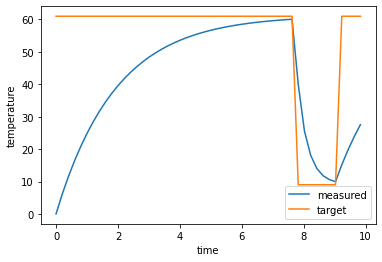

In [110]:
import time
import matplotlib.pyplot as plt
from simple_pid import PID


class WaterBoiler:
    """
    Simple simulation of a water boiler which can heat up water
    and where the heat dissipates slowly over time
    """

    def __init__(self):
        self.water_temp = 0
        # Panda 70 hp
        #self.max_power = 70
        #self.max_break = 70
        # Countach
        self.max_power = 375
        self.max_break = 200

    def update(self, boiler_power, dt):
        if boiler_power > 0:
            # Boiler can only produce heat, not cold
            self.water_temp += 0.1 * boiler_power * dt
        elif boiler_power < 0:
            self.water_temp += 0.5 * boiler_power * dt
        else:
            # Some heat dissipation
            self.water_temp -= 0.5 * dt
        return self.water_temp


if __name__ == '__main__':
    boiler = WaterBoiler()
    water_temp = boiler.water_temp

    pid = PID(5, 0.01, 0.1, setpoint=water_temp)
    pid.output_limits = (-boiler.max_break, boiler.max_power)
    pid.setpoint = 61
    # pid.sample_time = 0.01  # Update every 0.01 seconds

    start_time = time.time()
    last_time = start_time

    flag = False

    # Keep track of values for plotting
    setpoint, y, x = [], [], []

    while time.time() - start_time < 10:
        current_time = time.time()
        dt = current_time - last_time

        power = pid(water_temp)
        water_temp = boiler.update(power, dt)

        x += [current_time - start_time]
        y += [water_temp]
        setpoint += [pid.setpoint]
        print(power, water_temp)
        # if current_time - start_time > 1:
        #     pid.setpoint = 66

        if water_temp > 60 and not flag:
            flag = True
            pid.setpoint = 9
            print(pid.setpoint, water_temp)
        elif water_temp < 10 and flag:
            flag = False
            pid.setpoint = 61
            print(pid.setpoint, water_temp)

        last_time = current_time
        time.sleep(0.2)

    plt.plot(x, y, label='measured')
    plt.plot(x, setpoint, label='target')
    plt.xlabel('time')
    plt.ylabel('temperature')
    plt.legend()
    plt.show()

In [3]:
for i in range(5):
    print(i)

0
1
2
3
4


In [5]:
import random
random.randint(0, min(0, -1))

0

In [ ]:
 boiler = WaterBoiler()
water_temp = boiler.water_temp

pid = PID(5, 0.01, 0.1, setpoint=water_temp)
pid.output_limits = (-boiler.max_break, boiler.max_power)
pid.setpoint = 61
# pid.sample_time = 0.01  # Update every 0.01 seconds

start_time = time.time()
last_time = start_time

flag = False

# Keep track of values for plotting
setpoint, y, x = [], [], []

while time.time() - start_time < 10:
    current_time = time.time()
    dt = current_time - last_time

    power = pid(water_temp)
    water_temp = boiler.update(power, dt)

    x += [current_time - start_time]
    y += [water_temp]
    setpoint += [pid.setpoint]
    print(power, water_temp)
    # if current_time - start_time > 1:
    #     pid.setpoint = 66

    if water_temp > 60 and not flag:
        flag = True
        pid.setpoint = 9
        print(pid.setpoint, water_temp)
    elif water_temp < 10 and flag:
        flag = False
        pid.setpoint = 61
        print(pid.setpoint, water_temp)

    last_time = current_time
    time.sleep(0.2)

plt.plot(x, y, label='measured')
plt.plot(x, setpoint, label='target')
plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()
plt.show()